In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("eureka.csv")
df_actual_pair_distance = pd.read_csv("measured_pairwise_distance.csv")
df = df.sort_values(by='id', ascending=True)

In [2]:
def get_df_pairwise_distance(df_input):
    # Select all aruco markers that follow the circumference (all pairs)
    df_on_circumference = df_input[df_input['id'] < 100]


    df_even_ids = df_on_circumference[df_on_circumference['id'] % 2 == 0]
    df_odd_ids = df_on_circumference[df_on_circumference['id'] % 2 == 1]

    # take the pairwise difference
    # mainly to get relative x, y and z distance
    df_pair_difference = df_odd_ids.add(-df_even_ids.values,axis=0)
    df_pair_difference.drop('id', axis=1, inplace=True)
    df_pair_difference['id'] = df_even_ids['id'].values
    df_pair_difference['actual_distance_xyz'] = df_actual_pair_distance['measured_distance'].values

    # calculate euclidean distance from the relative x, y and z distances
    df_pair_difference['distance_xyz'] = np.sqrt( df_pair_difference['tx']**2 + df_pair_difference['ty']**2 + df_pair_difference['tz']**2 )
    return df_pair_difference

In [3]:
df_pair_difference = get_df_pairwise_distance(df)

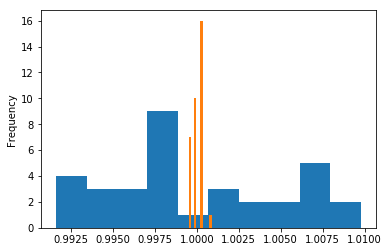

In [4]:
## Here it's assumed that the mean of the pairwise measured distances and opencv aruco distance are the same.
# From this assumption, a scaling factor can be yielded by dividing the two means

# plot the opencv aruco marker distance distribution, normalized around 1
pair_difference_mean = df_pair_difference['distance_xyz'].mean()
pair_difference_std = df_pair_difference['distance_xyz'].std()
(df_pair_difference['distance_xyz']/pair_difference_mean).plot(kind='hist')

# plot the measured distance distribution, normalized around 1
actual_mean = df_actual_pair_distance['measured_distance'].mean()
actual_std = df_actual_pair_distance['measured_distance'].std()
(df_actual_pair_distance['measured_distance']/actual_mean).plot(kind='hist')

scaling_factor = actual_mean/pair_difference_mean

In [5]:
# energy function for how close a set of points are to a plane (Ax+By+Cz=D, with D=1)
def energy_function(plane_normal):
    # sum over all (ax + by + cz - 1)**2
    return (((df_xyz*plane_normal).sum(axis=1)-1)**2).sum(axis=0)

# how close a point is to a plane, with a scaling factor k as the variable
def energy_function_with_scalar(k):
    # 
    return ((get_plane_z(k*xyz['tx'], k*xyz['ty'], plane_normal)-k*xyz['tz'])**2)

# given x, y and a plane (Ax+By+Cz=1), what is z?
def get_plane_z(x, y, plane_normal):
    A, B, C = plane_normal
    return (-A*x-B*y+1)/C

def estimate_plane():
    # initialise to some arbitrary plane
    init_plane_normal=[0,0,1]

    # Use energy function to estimate the floor as a plane
    res = minimize(energy_function, init_plane_normal, method='Nelder-Mead', tol=1e-8)
    res.x
    plane_normal = res.x
    return plane_normal

In [6]:
from scipy.optimize import minimize


# aruco marker positional data to be used in the energy function
df_xyz = df[['tx','ty','tz']]

plane_normal = estimate_plane()

# By assuming that the direction of the aruco marker vectors are correct,
# the vectors can be projected into the estimated floor plane.
# Performed by finding where k*(x,y,z) is a point on the plane, k being a variable
df_xyz_on_plane = df_xyz.copy()
count = -1
for i,row in df_xyz.iterrows():
    count = count + 1
    init_k=1.0
    xyz = row
    res = minimize(energy_function_with_scalar, init_k, method='Nelder-Mead', tol=1e-8)
    k = res.x[0]
    df_xyz_on_plane.iloc[count] = k*df_xyz_on_plane.iloc[count]

# this df contains the new coordinates that are projected into the plane
df_xyz_on_plane['id'] = df['id']



In [7]:
# same as above pairwise distance, but with plane coordinates
df_on_plane_diff = get_df_pairwise_distance(df_xyz_on_plane)

1.7263873860158416 1.7282088877340631


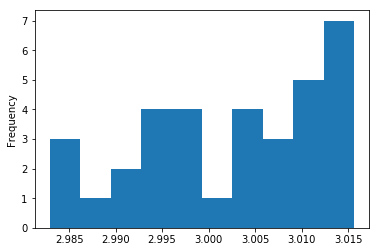

In [8]:
scaling_factor2 = (df_on_plane_diff['actual_distance_xyz']/df_on_plane_diff['distance_xyz']).mean()
(scaling_factor2*df_on_plane_diff['distance_xyz']).plot(kind='hist')

print(scaling_factor, scaling_factor2)

In [9]:
## The actual cam2floor distance will be used to assess how good a floor plane estimation is.

# x-mark position
# formula used:
# xp = fx*(pixel-cx)
# yp = fy*(pixel-cx)
xp= 0.0663123588482741
yp= -0.023728146422643644

actual_cam2floor_dist = 2.547

xyz = {'tx':xp, 'ty':yp, 'tz':1}
init_k=1.0

# find k value for where vector for principal point projects onto the estimated floor plane
res = minimize(energy_function_with_scalar, init_k, method='Nelder-Mead', tol=1e-10)
k = res.x[0]

k_xyz = scaling_factor*k*np.array(list(xyz.values()))
kx, ky, kz = k_xyz
cam2floor_dist = np.sqrt( kx**2 + ky**2 + kz**2 )
# principal point to floor distance
pp2floor_dist = scaling_factor*get_plane_z(0, 0, plane_normal)

print("Circle center to floor plane distance = %.3f m" % cam2floor_dist)
print("Actual circle center to floor distance = %.3f m" % actual_cam2floor_dist)
print("Difference = %.3f m" % abs(cam2floor_dist-actual_cam2floor_dist))
#print("Camera center projected onto the floor plane = %.3fm" % pp2floor_dist)
print("Difference = %.2f %%" % abs(100-100*(cam2floor_dist/actual_cam2floor_dist)))


Circle center to floor plane distance = 2.510 m
Actual circle center to floor distance = 2.547 m
Difference = 0.037 m
Difference = 1.47 %


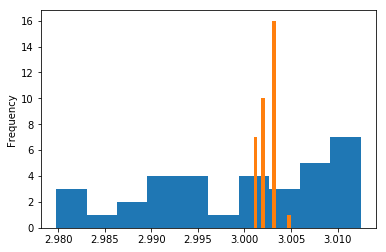

In [10]:
df_all = df.copy()
df_all['tx'] = scaling_factor*df['tx']
df_all['ty'] = scaling_factor*df['ty']
df_all['tz'] = scaling_factor*df['tz']
df_all['tx_fpe'] = scaling_factor*df_xyz_on_plane['tx']
df_all['ty_fpe'] = scaling_factor*df_xyz_on_plane['ty']
df_all['tz_fpe'] = scaling_factor*df_xyz_on_plane['tz']

#df_all['pair_dist'] = 

df_all['actual_pair_dist'] = df_pair_difference['actual_distance_xyz']
df_all['pair_dist'] = scaling_factor*df_pair_difference['distance_xyz']
df_all['pair_dist_fpe'] = scaling_factor*df_on_plane_diff['distance_xyz']
df_all.head(10)

df_all['pair_dist_fpe'].plot(kind='hist')
df_all['actual_pair_dist'].plot(kind='hist')

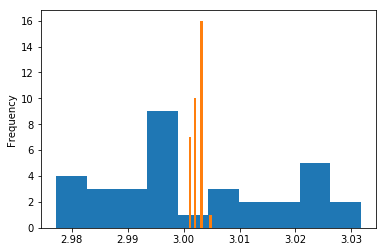

In [11]:
df_all['pair_dist'].plot(kind='hist')
df_all['actual_pair_dist'].plot(kind='hist')

In [41]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)


# aruco marker's coordinates, when projected into the plane
trace1 = go.Scatter3d(
    name='Aruco markers on plane',
    x=df_all['tx_fpe'],
    y=df_all['ty_fpe'],
    z=df_all['tz_fpe'],
    mode='markers',
    marker=dict(
        size=2,
        line=dict(
            color='orange',
            width=0.5
        ),
        #opacity=0.8
    )
)

# raw aruco marker's coordinates
trace2 = go.Scatter3d(
    name='Raw aruco markers',
    x=df_all['tx'],
    y=df_all['ty'],
    z=df_all['tz'],
    mode='markers',
    marker=dict(
        size=2,
        line=dict(
            color='magenta',
            width=0.5
        ),
        opacity=0.5
    )
)

# camera to plane projection vector
trace3 = go.Scatter3d(
    name='Camera direction',
    x=[0,0],
    y=[0,0],
    z=[0,pp2floor_dist],
    mode='line',
    marker=dict(
        size=1,
        line=dict(
            color='magenta',
            width=0.5
        ),
        opacity=1.0
    )
)

# camera position
trace4 = go.Scatter3d(
    name='Camera position',
    x=[0],
    y=[0],
    z=[0],
    mode='markers',
    marker=dict(
        size=6,
        line=dict(
            color='magenta',
            width=0.5
        ),
        opacity=0.8
    )
)

# camera to circle center
trace5 = go.Scatter3d(
    name='Camera to circle center',
    x=[0,kx],
    y=[0,ky],
    z=[0,kz],
    mode='line',
    marker=dict(
        size=1,
        line=dict(
            color='magenta',
            width=0.5
        ),
        opacity=1.0
    )
)

fpe_x, fpe_y, fpe_z = plane_normal/np.linalg.norm(plane_normal)*actual_cam2floor_dist
# plane estimation normal
trace6 = go.Scatter3d(
    name='Camera to circle center',
    x=[0,fpe_x],
    y=[0,fpe_y],
    z=[0,fpe_z],
    mode='line',
    marker=dict(
        size=1,
        line=dict(
            color='black',
            width=0.5
        ),
        opacity=1.0
    )
)

index=0
fpe_x2, fpe_y2, fpe_z2 = plane_normal_list[index]/np.linalg.norm(plane_normal_list[index])*actual_cam2floor_dist
# plane estimation normal
trace7 = go.Scatter3d(
    name='Camera to circle center',
    x=[0,fpe_x2],
    y=[0,fpe_y2],
    z=[0,fpe_z2],
    mode='line',
    marker=dict(
        size=1,
        line=dict(
            color='orange',
            width=0.5
        ),
        opacity=1.0
    )
)


data = [trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
    ),
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1,
            ),
            center=dict(
                x=0,
                y=0,
                z=0
            ),
            eye=dict(
                x=0,
                y=0,
                z=-1,
            )
        )
    ),
    
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple-3d-scatter')

In [38]:
nr_of_samples = 2
am_sample_size = range(3,10+1)

df_fpe = pd.DataFrame(columns=['ids', 'nr_of_ams', 'plane_normal'])
ids_list = []
nr_of_ams_list = []
plane_normal_list = []
for nr_of_ams in am_sample_size:
    print(nr_of_ams)
    for i in range(0, nr_of_samples):
        #sample!
        df_sample = df_all.sample(n=nr_of_ams, replace=False, random_state=nr_of_ams*10000+i)
        df_xyz = df_sample[['tx', 'ty', 'tz']]
        est_plane_normal = estimate_plane()
        ids_list.append(df_sample.index)
        nr_of_ams_list.append(nr_of_ams)
        plane_normal_list.append(est_plane_normal)
        
        #raw ams
        #fpe ams
        
df_fpe['ids'] = ids_list
df_fpe['nr_of_ams'] = nr_of_ams_list
df_fpe['plane_normal'] = plane_normal_list

3
4
5
6
7
8
9
10


,ids,nr_of_ams,plane_normal
0,"Int64Index([40, 36, 99], dtype='int64')",3,"[0.02611614621015884, -0.01768192743417259, 0...."
1,"Int64Index([97, 52, 29], dtype='int64')",3,"[0.033959080034444714, 0.002492743879175598, 0..."
2,"Int64Index([4, 16, 69, 33], dtype='int64')",4,"[0.032860882083247105, 0.002519661521190818, 0..."
3,"Int64Index([43, 100, 103, 65], dtype='int64')",4,"[0.024602378838676484, -0.007668072815405952, ..."
4,"Int64Index([93, 78, 5, 22, 67], dtype='int64')",5,"[0.02510510308498254, -0.008450264138491868, 0..."
5,"Int64Index([98, 71, 82, 104, 23], dtype='int64')",5,"[0.027577974400668975, -0.008379826576558, 0.3..."
6,"Int64Index([25, 44, 53, 99, 19, 104], dtype='i...",6,"[0.024045112385148303, -0.015406951614628784, ..."
7,"Int64Index([22, 53, 33, 61, 9, 81], dtype='int...",6,"[0.025654884546837203, -0.008449297159135035, ..."
8,"Int64Index([16, 109, 98, 4, 73, 106, 0], dtype...",7,"[0.025874316304725774, -0.010233816448731831, ..."
9,"Int64Index([71, 36, 40, 88, 28, 96, 21], dtype...",7,"[0.02791592287486917, -0.007341887904431807, 0..."


array([0.03395908, 0.00249274, 0.39873873])

In [36]:
abs(plane_normal_list-plane_normal)

k_xyz_norm = k_xyz/np.linalg.norm(k_xyz)
print(k_xyz_norm)

print((plane_normal/np.linalg.norm(plane_normal)*actual_cam2floor_dist))



[ 0.0661485  -0.02366951  0.99752901]
[ 0.15851261 -0.06538722  2.54122161]


array([ 0.04281159, -0.01765999,  0.68634124])

# Floor plane estimation (fpe) experiment

## "Can the floor be estimated as a plane using aruco marker data?"
### Will be answered by developing an algorithm to estimate the floor plane, which will then be assessed.
### Assuming that the floor is perpendicular to gravitation, the normal of the estimated plane can be compared to the the normal created from the camera (which is mounted exactly above the x-marked center of the circle) to the x-marked center.
### Will also be assessed by the variance of distance to the aruco tags in comparison to the floor plane
## "If so, how many are needed and should they be placed in a certain way?"
### Will be answered by sampling different amounts of aruco markers from the dataset. How well does 3 aruco markers resemble the "ground truth"? 4? 5?
### To give an idea of how this would actually affect the anchor localisation error, virtual anchor points are placed on the ground truth plane, on the circumference of the circle. Individual X Y and Z will be assessed, as well as total error vector length.

In [15]:
'''
Thoughts on the experiment:

*Placing the aruco markers too close to each other (when they are used for floor plane estimation) is probably something to avoid.
 If z error is approximated to be the same independent of how far out from the principal point (~Hangprinter floor origin),
 then they should be placed as far out from the center as possible. However, some other factors are counteracting this, such as
 distortion, which becomes greater out towards the corners and edges.
 
 *

'''

'\nThoughts on the experiment:\n\n*Placing the aruco markers too close to each other (when they are used for floor plane estimation) is probably something to avoid.\n If z error is approximated to be the same independent of how far out from the principal point (~Hangprinter floor origin),\n then they should be placed as far out from the center as possible. However, some other factors are counteracting this, such as\n distortion, which becomes greater out towards the corners and edges.\n \n *\n\n'

# Pairwise distance and rotational difference

### "How accurate is the coordinate data?"
### Will be answered by looking at the distribution and variation of pairwise distance
### "How accurate is the rotational data?"
### Will be answered by looking at the pairwise z-rotation. Is it the same? Distribution and variance?
### Will be answered by looking at how well the raw aruco marker rotational data compares to the normal of the estimated floor plane. Distribution and variance?
